# Lambda-Adaptive TD($\lambda$)
_
**Author:** Daniel Mastropietro  
**Date:** 19-Apr-2020
_

## Analysis of TD($\lambda$) and $\lambda$-return (here called MC($\lambda$)) on a 1D gridworld

A 1D gridworld with 21 states is considered, having the leftmost and rightmost states as terminal states giving respectively rewards -1.0 and +1.0 when attained.

The agent follows the random walk policy and its goal is to **estimate the state value function**.

Three different learners are considered:
- TD($\lambda$)
- $\lambda$-return (here called MC($\lambda$))
- $\lambda$-adaptive TD (new proposal), where $\lambda$ is allowed to vary at each time step, as a measure of the magnitude of the temporal gradient of the observed return.

**The goals of this exercise are:**  
1) Test an RL-framework that was created as a factory of policies and learners to be applied to different environments.  
2) To confirm that the implementation of the algorithms work on a very simple example.  
3) To get a feeling of the performance of an $\lambda$-adaptive TD algorithm.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm    # cm is for colormaps (e.g. cm.get_cmap())
from matplotlib import rc
rc('text', usetex=False)  # When usetex=True, mathematical symbols can be used in plots via Tex expressions enclosed in $..$

import runpy
runpy.run_path("../setup.py")

#from Python.lib import environments, agents
from Python.lib.environments import EnvironmentDiscrete
from Python.lib.agents import GeneralAgent

from Python.lib.environments import gridworlds
from Python.lib.agents.policies import random_walks
from Python.lib.agents.learners import mc
from Python.lib.agents.learners import td

from Python.lib.simulators import Simulator

%matplotlib inline

Directory:
E:\Daniel\Projects\PhD-RL-Toulouse\projects
has been prepended to the module search path.


### Plotting functions

In [2]:
def plot_rmse_by_episode(rmse_mean_values, rmse_se_values=None, max_rmse=None, color="black", hold=False, subtitle="", fontsize=12):
    """
    Plots the average RMSE values (over states) by episode
    
    @param rmse_mean_values: numpy array containing the average RMSE value per episode.
    @param rmse_se_values: (optional) numpy array containing an error measure of the average RMSE, e.g. their standard error.
    @param max_mse: (optional) maximum RMSE value to show in the plot (for visual comparison reasons)
    """

    nepisodes = len(rmse_mean_values)
    if max_rmse is None:
        max_rmse = np.max(rmse_mean_values)*1.1

    if not hold:
        plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.plot(np.arange(nepisodes)+1, rmse_mean_values, color=color)
    if rmse_se_values is not None:
        ax.errorbar(np.arange(nepisodes)+1, rmse_mean_values, yerr=rmse_se_values, capsize=4, color=color)
    ax.set_xticks(np.arange(nepisodes)+1)
    ax.set_ylim((0, max_rmse))
    ax.set_xlabel("Episode", fontsize=fontsize)
    ax.set_ylabel("RMSE", fontsize=fontsize)    
    ax.set_title("Average RMSE by episode {}".format(subtitle), fontsize=fontsize)

### Simulation functions

In [3]:
def simulate(env, policy, learner,
             seed=None, nexperiments=10, nepisodes=20, start=None,
             alphas=[0.2], lambdas=[0.9], gamma=0.8, adjust_alpha=False, alpha_min=0.,
             lambda_min=0., burnin=False,  # Parameters used in the adaptive TD lambda
             plot=True, max_alpha=1, max_rmse=0.5, error_bars=True,
             verbose=True, debug=False, show_warnings=True):
    "Simulates an environment using the given policy and learner"

    # Remove overflow warnings that happen when lambda and/or alpha are too large...    
    import warnings
    if show_warnings:
        warnings.filterwarnings("once")
    else:
        warnings.filterwarnings("ignore")

    learner_module = learner.__module__.upper()
    learner_name = learner_module[ learner_module.rfind(".")+1:]

    # Plotting setup
    if plot:
        colormap = cm.get_cmap("jet")
        fig = plt.figure(figsize=(20, 10))
        #(ax_full, ax_scaled, ax_rmse_by_episode) = fig.subplots(1,3)
        (ax_full, ax_scaled) = fig.subplots(1,2)

    n_lambdas = len(lambdas)
    n_alphas = len(alphas)
    n_simul = n_lambdas*n_alphas

    # List of dictionaries, each containing the characteristic of each parameterization considered
    df_results = pd.DataFrame(data=np.nan*np.zeros((n_simul, 5)), columns=['idx_lambda', 'lambda', 'alpha', 'rmse_mean', 'rmse_se'])
    legend_label = []
    # Average RMSE obtained at the LAST episode run for each parameter set and their standard error
    rmse_mean_values = np.nan*np.zeros((n_lambdas, n_alphas))
    rmse_se_values = np.nan*np.zeros((n_lambdas, n_alphas))
    # Average RMSE over the episodes run for each parameter set and their standard error 
    rmse_episodes_mean = np.nan*np.zeros((n_lambdas, n_alphas))
    rmse_episodes_se = np.nan*np.zeros((n_lambdas, n_alphas))
    # RMSE over the episodes averaged over ALL parameter set runs with their standard error
    rmse_episodes_mean_values = np.zeros(nepisodes)
    rmse_episodes_se2_values = np.zeros(nepisodes)
    idx_simul = -1
    for idx_lmbda, lmbda in enumerate(lambdas):
        rmse_mean_lambda = []
        rmse_se_lambda = []
        rmse_episodes_mean_lambda = []
        rmse_episodes_se_lambda = []
        for alpha in alphas:
            idx_simul += 1
            if verbose:
                print("Parameter set {} of {}: lambda = {:.2f}, alpha = {:.2f} --->" \
                      .format(idx_simul+1, n_simul, lmbda, alpha), end=" ")
            if isinstance(learner, td.LeaTDLambdaAdaptive):
                learner.setParams(alpha=alpha, gamma=gamma, lmbda=lmbda, adjust_alpha=adjust_alpha, alpha_min=alpha_min, lambda_min=lambda_min, burnin=burnin)
            else:
                learner.setParams(alpha=alpha, gamma=gamma, lmbda=lmbda, adjust_alpha=adjust_alpha, alpha_min=alpha_min)
            learner.reset(reset_episode=True, reset_value_functions=True)
            agent = GeneralAgent(pol_rw,
                                 learner)
            # NOTE: Setting the seed here implies that each set of experiments
            # (i.e. for each combination of alpha and lambda) yields the same outcome in terms
            # of visited states and actions.
            # This is DESIRED --as opposed of having different state-action outcomes for different
            # (alpha, lambda) settings-- as it better isolates the effect of alpha and lambda.
            # VERIFIED BY RUNNING IN DEBUG MODE!
            sim = Simulator(env, agent, seed=seed, debug=debug)

            # Run the simulation and store the results
            rmse_mean, rmse_se, rmse_episodes_mean_idx, rmse_episodes_se_idx = \
                                                sim.simulate(nexperiments=nexperiments,
                                                             nepisodes=nepisodes,
                                                             start=start,
                                                             verbose=False)
            df_results.loc[idx_simul] = [idx_lmbda, lmbda, alpha, rmse_mean, rmse_se]
            rmse_mean_lambda += [rmse_mean]
            rmse_se_lambda += [rmse_se]
            # Average RMSE over all the episodes (this is what is reported by Sutton in their graphs in Chapter 12)
            # (not the best measure to report according to me... we should just look at the RMSE once the LAST episode is run
            # since the agent learns more after every episode!)
            rmse_episodes_mean_lambda += [np.mean(rmse_episodes_mean_idx)]
            rmse_episodes_se_lambda += [np.std(rmse_episodes_mean_idx) / np.sqrt(nepisodes)]
            # Average RMSE by episode and their standard error
            rmse_episodes_mean_values += rmse_episodes_mean_idx
            rmse_episodes_se2_values += rmse_episodes_se_idx**2

            if verbose:
                print("\tRMSE = {:.3g} ({:.3g})".format(rmse_mean, rmse_se))

        # Store the RMSE results for the current lambda
        rmse_mean_values[idx_lmbda] = np.array(rmse_mean_lambda)
        rmse_se_values[idx_lmbda] = np.array(rmse_se_lambda)
        rmse_episodes_mean[idx_lmbda] = np.array(rmse_episodes_mean_lambda)
        rmse_episodes_se[idx_lmbda] = np.array(rmse_episodes_se_lambda)

        if plot:
            # Plot the average RMSE for the current lambda as a function of alpha
            #rmse2plot = rmse_mean_lambda
            #rmse2plot_error = rmse_se_lambda
            #ylabel = "Average RMSE over all {} states, at the end of episode {}, averaged over {} experiments".format(env.getNumStates(), nepisodes, nexperiments)
            rmse2plot = rmse_episodes_mean_lambda
            rmse2plot_error = rmse_episodes_se_lambda
            ylabel = "Average RMSE over all {} states, first {} episodes, and {} experiments".format(env.getNumStates(), nepisodes, nexperiments)

            # Map blue to the largest lambda and red to the smallest lambda (most similar to the color scheme used in Sutton, pag. 295)
            color = colormap( 1 - idx_lmbda / np.max((1, n_lambdas-1)) )
            ax_full.plot(alphas, rmse2plot, '.-', color=color)
            if error_bars:
                ax_full.errorbar(alphas, rmse2plot, yerr=rmse2plot_error, capsize=4, color=color)
            ax_full.set_title("Error measure for different (lambda, alpha) (FULL scale)")
            ax_full.set_xlabel("alpha")
            ax_full.set_ylabel(ylabel)
            legend_label += ["lam={:.2g}".format(lmbda)]

    # Average RMSE by episode for rate of convergence analysis
    rmse_episodes_mean_overall = rmse_episodes_mean_values / n_simul
    rmse_episodes_se_overall = np.sqrt(rmse_episodes_se2_values) / n_simul  # This is sqrt( sum(SE^2) ) / n_simul, based on calculations done on paper on 19-Apr-2020

    # Scaled plot (for comparison purposes)
    if plot:
        for idx_lmbda, lmbda in enumerate(lambdas):
            #rmse2plot = rmse_mean_values[idx_lmbda]
            #rmse2plot_error = rmse_se_values[idx_lmbda]
            rmse2plot = rmse_episodes_mean[idx_lmbda]
            rmse2plot_error = rmse_episodes_se[idx_lmbda]
            color = colormap( 1 - idx_lmbda / np.max((1, n_lambdas-1)) )
            ax_scaled.plot(alphas, rmse2plot, '.-', color=color)
            if error_bars:
                ax_scaled.errorbar(alphas, rmse2plot, yerr=rmse2plot_error, capsize=4, color=color)
            ax_scaled.set_title("Error measure for different (lambda, alpha) (ZOOMED for visual comparison)")
            ax_scaled.set_xlabel("alpha")
            ax_scaled.set_xlim((0, max_alpha))
            ax_scaled.set_ylim((0, max_rmse))

        plt.figlegend(legend_label)
        fig.suptitle("{}(lambda): gamma = {:.2g}, #experiments = {}, #episodes = {}"\
                     .format(learner_name, gamma, nexperiments, nepisodes), fontsize=18)

    # Restore warnings default
    warnings.filterwarnings("default")

    return df_results, pd.DataFrame({'episode': np.arange(nepisodes) + 1, 'rmse_mean': rmse_episodes_mean_overall, 'rmse_se': rmse_episodes_se_overall}) 

In [4]:
# The environment
env = gridworlds.EnvGridworld1D(length=21)

# Possible policies and learners for agents
pol_rw = random_walks.PolRandomWalkDiscrete(env)
lea_td = td.LeaTDLambda(env)
lea_td_adap = td.LeaTDLambdaAdaptive(env)
lea_mc = mc.LeaMCLambda(env)

#-- Define hyperparameter values
gamma = 1  # Undiscounted task, as stated in Example 6.2, Sutton, pag. 125 when they present the 5-step 1D random walk extended later on to 19-step random walk
# Grid values
n_lambdas = 10
n_alphas = 8
lambdas_grid = np.linspace(0, 1, n_lambdas)
alphas_grid = np.linspace(0.1, 0.7, n_alphas)
# Ad-hoc values
lambdas_adhoc_mc = [0, 0.4, 0.8, 0.9, 0.95, 0.99, 1]
alphas_adhoc_mc = [0.01] + list(np.linspace(0.1, 1.2, 10))
lambdas_adhoc_td = [0, 0.4, 0.8, 0.9, 0.95, 0.99, 1]
alphas_adhoc_td = [0.01] + list(np.linspace(0.1, 0.9, 10))

### 1) TD($\lambda$), $\gamma = 1$, #Experiments = 1, Performance Measure: Average RMSE over first 10 episodes

    idx_lambda  lambda     alpha      rmse_mean  rmse_se
0          0.0    0.00  0.010000   4.884752e-01      NaN
1          0.0    0.00  0.100000   2.537833e-01      NaN
2          0.0    0.00  0.188889   1.100735e-01      NaN
3          0.0    0.00  0.277778   9.829165e-02      NaN
4          0.0    0.00  0.366667   1.682675e-01      NaN
5          0.0    0.00  0.455556   2.424155e-01      NaN
6          0.0    0.00  0.544444   3.161493e-01      NaN
7          0.0    0.00  0.633333   3.904847e-01      NaN
8          0.0    0.00  0.722222   4.653515e-01      NaN
9          0.0    0.00  0.811111   5.464988e-01      NaN
10         0.0    0.00  0.900000   6.846369e-01      NaN
11         1.0    0.40  0.010000   5.081437e-01      NaN
12         1.0    0.40  0.100000   4.076842e-01      NaN
13         1.0    0.40  0.188889   3.244158e-01      NaN
14         1.0    0.40  0.277778   2.519886e-01      NaN
15         1.0    0.40  0.366667   1.897343e-01      NaN
16         1.0    0.40  0.45555

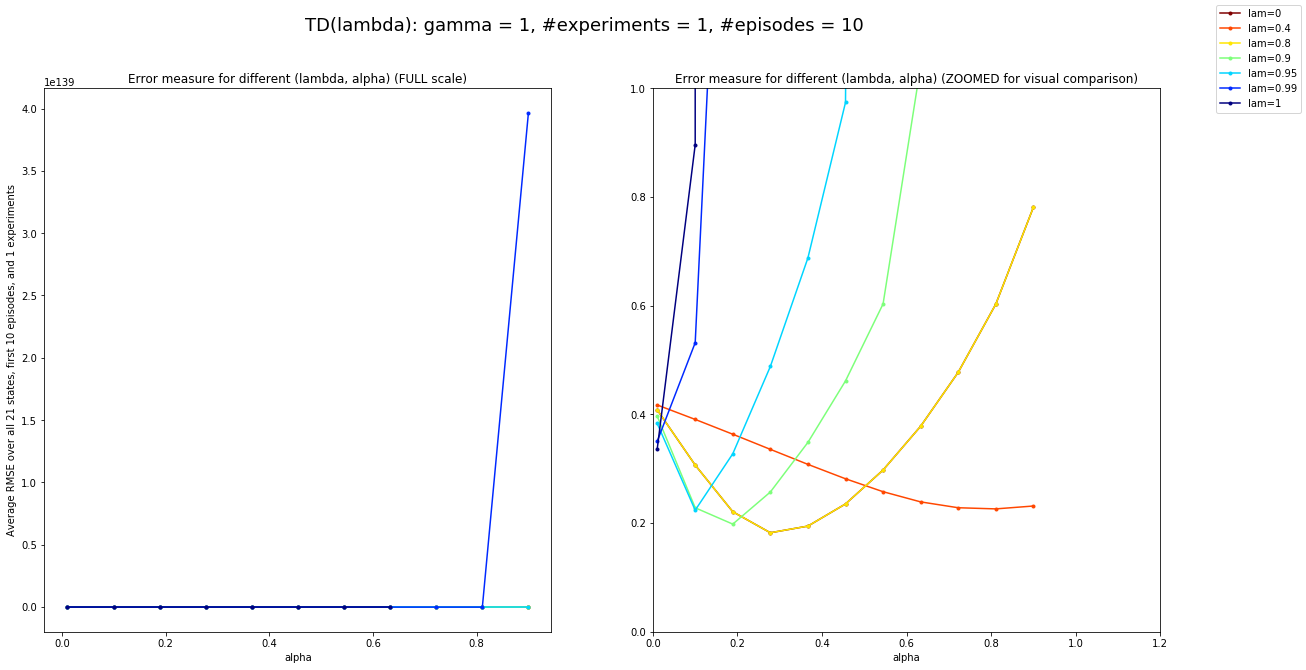

In [5]:
# Simulation parameters
seed = 1713
nexperiments = 1
nepisodes = 10

df_results_td, df_rmse_by_episode_td = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=alphas_adhoc_td, lambdas=lambdas_adhoc_td, gamma=gamma, adjust_alpha=False,
                         max_alpha=np.max(alphas_adhoc_mc), max_rmse=1, error_bars=False,
                         verbose=False, debug=False, show_warnings=False)
print(df_results_td)

The RMSE diverges very "quickly" for smaller and smaller $\alpha$'s as $\lambda$ gets larger.

### 2) MC($\lambda$), $\gamma = 1$, #Experiments = 1, Performance Measure: Average RMSE over first 10 episodes

    idx_lambda  lambda     alpha  rmse_mean  rmse_se
0          0.0    0.00  0.010000   0.488671      NaN
1          0.0    0.00  0.100000   0.268356      NaN
2          0.0    0.00  0.222222   0.110043      NaN
3          0.0    0.00  0.344444   0.104530      NaN
4          0.0    0.00  0.466667   0.161709      NaN
5          0.0    0.00  0.588889   0.215152      NaN
6          0.0    0.00  0.711111   0.263650      NaN
7          0.0    0.00  0.833333   0.310781      NaN
8          0.0    0.00  0.955556   0.358526      NaN
9          0.0    0.00  1.077778   0.407728      NaN
10         0.0    0.00  1.200000   0.459317      NaN
11         1.0    0.40  0.010000   0.508160      NaN
12         1.0    0.40  0.100000   0.409809      NaN
13         1.0    0.40  0.222222   0.304258      NaN
14         1.0    0.40  0.344444   0.219607      NaN
15         1.0    0.40  0.466667   0.159410      NaN
16         1.0    0.40  0.588889   0.131980      NaN
17         1.0    0.40  0.711111   0.139088   

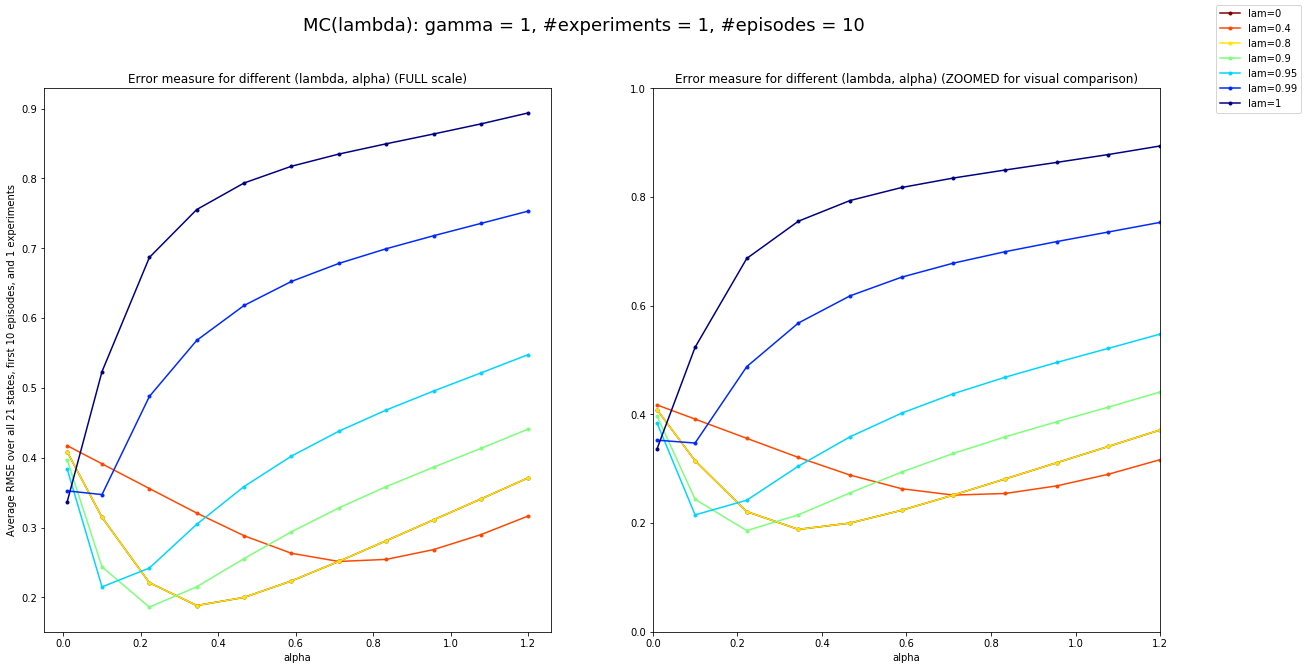

In [6]:
# Simulation setup
seed = 1713
nexperiments = 1
nepisodes = 10

df_results_mc, df_rmse_by_episode_mc = simulate(env, pol_rw, lea_mc,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=alphas_adhoc_mc, lambdas=lambdas_adhoc_mc, gamma=gamma, adjust_alpha=False,
                         max_alpha=np.max(alphas_adhoc_mc), max_rmse=1, error_bars=False,
                         verbose=False, debug=False, show_warnings=False)
print(df_results_mc)

The RMSE diverges much more slowly than the TD case as $\alpha$ increases beyond the optimum attained for each $\lambda$.

### 3) $\lambda$-adaptive TD, $\gamma = 1$, #Experiments = 1, Performance Measure: Average RMSE over first 10 episodes
This algorithm proposes to adapt $\lambda$ at each learning time step in the TD($\lambda$) algorithm by defining $\lambda$ as a function of the $\delta(t)$ TD error, i.e.:

$\delta(t) = R_{t+1} + \gamma V(S(t+1)) - V(S(t))$

where $V(s)$ is the estimated state value function for state $s$, and $S(t)$ is the state of the environment at time $t$.

The value of $\lambda$ is now allowed to change at each time step $t$ and is proposed as a sigmoid function of the $\delta(t)$ error *relative* to the estimated state value function at time $t$, namely:

$\lambda(t) = 1 - exp(- |\delta_{rel}(t)| )$

where $\delta_{rel}(t)$ is given by:

- $0$ if $V(S(t)) = 0$ and $\delta(t) = 0$
- $+\infty$ if $V(S(t)) = 0$ and $\delta(t) \neq 0$
- $\frac{\delta(t)}{V(S(t))}$ o.w.

Note that $\lambda(t) \to 0^+$ when $\delta_{rel}(t) \to 0$ and $\lambda(t) \to 1^-$ when $|\delta_{rel}(t)| \to +\infty$.

However, this adaptation is _not_ done for all time steps: in order to _accelerate_ the initial convergence of the algorithm for environments with terminal-only rewards, we use a fixed $\lambda$ for a time step as long as the _value function at the next time step has not been updated at least once_.

    idx_lambda  lambda     alpha  rmse_mean  rmse_se
0          0.0    0.00  0.010000   0.505489      NaN
1          0.0    0.00  0.100000   0.376350      NaN
2          0.0    0.00  0.188889   0.282168      NaN
3          0.0    0.00  0.277778   0.209902      NaN
4          0.0    0.00  0.366667   0.150545      NaN
5          0.0    0.00  0.455556   0.102394      NaN
6          0.0    0.00  0.544444   0.076989      NaN
7          0.0    0.00  0.633333   0.073706      NaN
8          0.0    0.00  0.722222   0.116836      NaN
9          0.0    0.00  0.811111   0.178269      NaN
10         0.0    0.00  0.900000   0.255265      NaN
11         1.0    0.40  0.010000   0.505489      NaN
12         1.0    0.40  0.100000   0.376350      NaN
13         1.0    0.40  0.188889   0.282168      NaN
14         1.0    0.40  0.277778   0.209902      NaN
15         1.0    0.40  0.366667   0.150545      NaN
16         1.0    0.40  0.455556   0.102394      NaN
17         1.0    0.40  0.544444   0.076989   

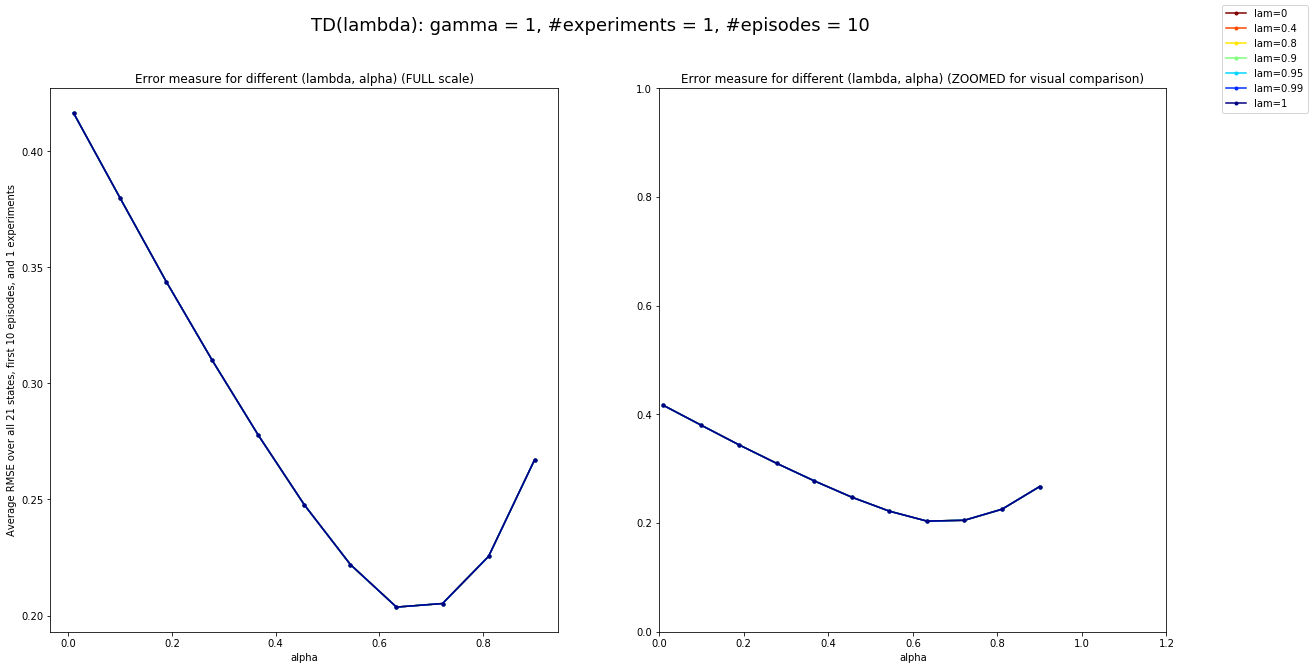

In [7]:
from importlib import reload
from Python.lib.agents.learners import td
reload(td)
from Python.lib.agents.learners import td
from Python.lib.agents.learners.td import LeaTDLambdaAdaptive
##from td import LeaTDLambdaAdaptive    # <-- Here I get the error that no module named 'td' exists... WHY??? (since reload(td) gives no error!!)

# Simulation parameters
seed = 1713
nexperiments = 1
nepisodes = 10

# Parameters specific to the adaptive case
lambda_min = 0.
burnin = False

df_results_td, df_rmse_by_episodes_td_adap = simulate(env, pol_rw, lea_td_adap,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=alphas_adhoc_td, lambdas=lambdas_adhoc_td, gamma=gamma, adjust_alpha=False,
                         lambda_min=lambda_min, burnin=burnin,
                         max_alpha=np.max(alphas_adhoc_mc), max_rmse=1, error_bars=False,
                         verbose=False, debug=False, show_warnings=False)
print(df_results_td)

In this case there is clearly **only one curve** since $\lambda$ is no longer a hyperparameter of the optimization problem.

### 4) Analysis of the rate of convergence
We now compare the evolution of the average RMSE (over all states and all experiments) among the three algorithms.

For each algorithm we choose the $\lambda$ and $\alpha$ parameters that correspond to the minimum RMSE from the above simulations, namely:

- TD($\lambda$): $\lambda = 0.8$, $\alpha = 0.3$  
- MC($\lambda$): $\lambda = 0.8$, $\alpha = 0.35$
- TD adaptive: $\alpha = 0.65$

We run 30 experiments with 10 episodes each.

In [5]:
# Simulation parameters
seed = 1713
nexperiments = 30
nepisodes = 10
#-- Optimum parameters for TD(lambda) and MC(lambda)
# Based on profile analysis WITHOUT adjusting alpha
# For TD(adaptive) we use the same parameters as TD(lambda) (although according to the adpative TD(lambda) plot, the best combination is lambda=0.9, alpha=0.38)
lambdas_opt = {'td': 0.8, 'mc': 0.8, 'td_adap': 0.8}
alphas_opt = {'td': 0.3, 'mc': 0.35, 'td_adap': 0.7}
# Based on profile analysis ADJUSTING alpha
#lambdas_opt = {'td': 0.9, 'mc': 0.9, 'td_adap': 0.95}
#alphas_opt = {'td': 0.2, 'mc': 1.2, 'td_adap': 0.38}

adjust_alpha = True
alpha_min = 0.1
lambda_min = 0.0
burnin = True

version = "0.4"
fontsize = 14

In [6]:
# TD(lambda)
df_results_td, df_rmse_by_episode_td_epi10 = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td']], lambdas=[lambdas_opt['td']], gamma=gamma, adjust_alpha=adjust_alpha,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda)")
print(df_rmse_by_episode_td_epi10)

RMSE by Episode for TD(lambda)
   episode  rmse_mean   rmse_se
0        1   0.381787  0.003253
1        2   0.328077  0.006659
2        3   0.293499  0.007528
3        4   0.267015  0.009604
4        5   0.240244  0.009618
5        6   0.211000  0.009075
6        7   0.195226  0.009502
7        8   0.186969  0.009346
8        9   0.182540  0.008876
9       10   0.176442  0.009204


In [7]:
# lambda-return
df_results_mc, df_rmse_by_episode_mc_epi10 = simulate(env, pol_rw, lea_mc,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['mc']], lambdas=[lambdas_opt['mc']], gamma=gamma, adjust_alpha=adjust_alpha,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for MC(lambda)")
print(df_rmse_by_episode_mc_epi10)

RMSE by Episode for MC(lambda)
   episode  rmse_mean   rmse_se
0        1   0.386131  0.002949
1        2   0.347753  0.005112
2        3   0.320632  0.005893
3        4   0.298073  0.007560
4        5   0.283116  0.008434
5        6   0.269258  0.007889
6        7   0.261893  0.008078
7        8   0.254979  0.008320
8        9   0.251176  0.008340
9       10   0.246306  0.008481


In [8]:
# Adaptive TD(lambda)
df_results_td_adap, df_rmse_by_episode_td_adap_epi10 = simulate(env, pol_rw, lea_td_adap,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td_adap']], lambdas=[lambdas_opt['td_adap']], gamma=gamma, adjust_alpha=adjust_alpha, alpha_min=alpha_min,
                         lambda_min=lambda_min, burnin=burnin,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda) adaptive")
print(df_rmse_by_episode_td_adap_epi10)

RMSE by Episode for TD(lambda) adaptive
   episode  rmse_mean   rmse_se
0        1   0.365681  0.006028
1        2   0.316673  0.009913
2        3   0.295374  0.011555
3        4   0.277818  0.012021
4        5   0.256746  0.011679
5        6   0.231769  0.012918
6        7   0.212395  0.013481
7        8   0.206623  0.012873
8        9   0.201415  0.012907
9       10   0.193049  0.012900


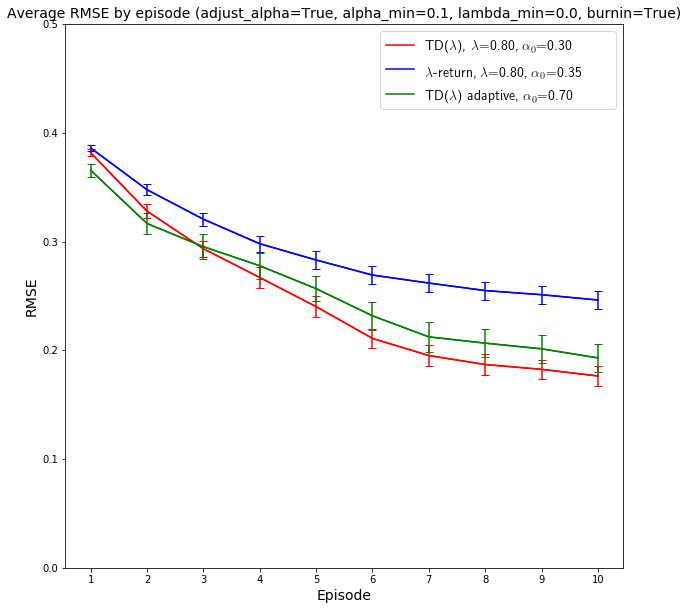

In [9]:
plot_rmse_by_episode(df_rmse_by_episode_td_epi10['rmse_mean'], df_rmse_by_episode_td_epi10['rmse_se'], color="red", max_rmse=0.5, fontsize=fontsize)
plot_rmse_by_episode(df_rmse_by_episode_mc_epi10['rmse_mean'], df_rmse_by_episode_mc_epi10['rmse_se'], color="blue", max_rmse=0.5, hold=True, fontsize=fontsize)
plot_rmse_by_episode(df_rmse_by_episode_td_adap_epi10['rmse_mean'], df_rmse_by_episode_td_adap_epi10['rmse_se'], color="green", max_rmse=0.5, hold=True,
                     subtitle="(adjust_alpha={}, alpha_min={}, lambda_min={}, burnin={})".format(adjust_alpha, alpha_min, lambda_min, burnin), fontsize=fontsize)
rc('text', usetex=True)
plt.legend([r'TD($\lambda$), $\lambda$={:.2f}, $\alpha_0$={:.2f}'.format(lambdas_opt['td'], alphas_opt['td']),
            r'$\lambda$-return, $\lambda$={:.2f}, $\alpha_0$={:.2f}'.format(lambdas_opt['mc'], alphas_opt['mc']),
            r'TD($\lambda$) adaptive, $\alpha_0$={:.2f}'.format(alphas_opt['td_adap'])], fontsize=fontsize)
rc('text', usetex=False)
plt.savefig("results/SimulateTDLambda-Gridworld1D-AdaptiveTDLambda-v{}-adjust_alpha={},alpha_min={},lambda_min={},burnin={}-Episodes10.png" \
            .format(version, adjust_alpha, alpha_min, lambda_min, burnin))

We observe that the RMSE in the $\lambda$-adaptive TD case decreases more slowly than the other two cases, but attains a smaller RMSE value at the end of the 10 episodes, with the important advantage that there is no need of defining hyperparameter $\lambda$.

In addition, the variability observed in the RMSE at each episode tends to be smaller.

#### What happens if we run each experiment for a longer number of episodes?

We now increase the number of episodes run per experiment from 10 to 50.

In [10]:
# Simulation parameters
seed = 1713
nexperiments = 30
nepisodes = 100

In [11]:
# TD(lambda)
df_results_td, df_rmse_by_episode_td = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td']], lambdas=[lambdas_opt['td']], gamma=gamma, adjust_alpha=adjust_alpha,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda)")
print(df_rmse_by_episode_td)

RMSE by Episode for TD(lambda)
    episode  rmse_mean   rmse_se
0         1   0.387376  0.003062
1         2   0.334579  0.006777
2         3   0.298889  0.007839
3         4   0.265048  0.008429
4         5   0.244073  0.009750
5         6   0.215821  0.009583
6         7   0.204426  0.010259
7         8   0.185658  0.009400
8         9   0.173259  0.010443
9        10   0.168004  0.010432
10       11   0.168046  0.010260
11       12   0.167720  0.010935
12       13   0.166281  0.010992
13       14   0.164911  0.010858
14       15   0.163817  0.010918
15       16   0.162631  0.010900
16       17   0.161537  0.010848
17       18   0.159816  0.010732
18       19   0.159231  0.010806
19       20   0.158581  0.010727
20       21   0.157872  0.010687
21       22   0.156546  0.010655
22       23   0.156128  0.010647
23       24   0.155375  0.010580
24       25   0.154865  0.010566
25       26   0.154255  0.010533
26       27   0.153372  0.010501
27       28   0.152914  0.010460
28       29 

In [12]:
# lambda-return
df_results_mc, df_rmse_by_episode_mc = simulate(env, pol_rw, lea_mc,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['mc']], lambdas=[lambdas_opt['mc']], gamma=gamma, adjust_alpha=adjust_alpha,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for MC(lambda)")
print(df_rmse_by_episode_mc)

RMSE by Episode for MC(lambda)
    episode  rmse_mean   rmse_se
0         1   0.392609  0.002772
1         2   0.348093  0.004869
2         3   0.319375  0.005506
3         4   0.299418  0.005933
4         5   0.288548  0.007323
5         6   0.273107  0.007415
6         7   0.266119  0.007546
7         8   0.254092  0.008096
8         9   0.248625  0.008451
9        10   0.245189  0.008593
10       11   0.243103  0.008508
11       12   0.240684  0.008579
12       13   0.238680  0.008775
13       14   0.237241  0.008793
14       15   0.235593  0.008729
15       16   0.234291  0.008723
16       17   0.233143  0.008673
17       18   0.231927  0.008630
18       19   0.230927  0.008635
19       20   0.230221  0.008634
20       21   0.229372  0.008644
21       22   0.228358  0.008640
22       23   0.227683  0.008615
23       24   0.226923  0.008583
24       25   0.226238  0.008620
25       26   0.225431  0.008619
26       27   0.224695  0.008605
27       28   0.224098  0.008612
28       29 

In [13]:
# Adaptive TD(lambda)
df_results_td_adap, df_rmse_by_episode_td_adap = simulate(env, pol_rw, lea_td_adap,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td_adap']], lambdas=[lambdas_opt['td_adap']], gamma=gamma, adjust_alpha=adjust_alpha, alpha_min=alpha_min,
                         lambda_min=lambda_min, burnin=burnin,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda) adaptive")
print(df_rmse_by_episode_td_adap)

RMSE by Episode for TD(lambda) adaptive
    episode  rmse_mean   rmse_se
0         1   0.368429  0.005600
1         2   0.325430  0.013105
2         3   0.310822  0.013890
3         4   0.289076  0.015429
4         5   0.278538  0.015679
5         6   0.253874  0.017469
6         7   0.241843  0.017090
7         8   0.238954  0.017581
8         9   0.232938  0.016973
9        10   0.225665  0.016678
10       11   0.220984  0.016872
11       12   0.211908  0.017038
12       13   0.210139  0.017049
13       14   0.204876  0.016827
14       15   0.198021  0.015932
15       16   0.190691  0.015831
16       17   0.187289  0.015693
17       18   0.181537  0.016375
18       19   0.181958  0.016528
19       20   0.177838  0.016754
20       21   0.178186  0.016602
21       22   0.174142  0.016582
22       23   0.173323  0.016500
23       24   0.171961  0.016313
24       25   0.171523  0.015949
25       26   0.171230  0.016375
26       27   0.168197  0.015841
27       28   0.165186  0.016089
28 

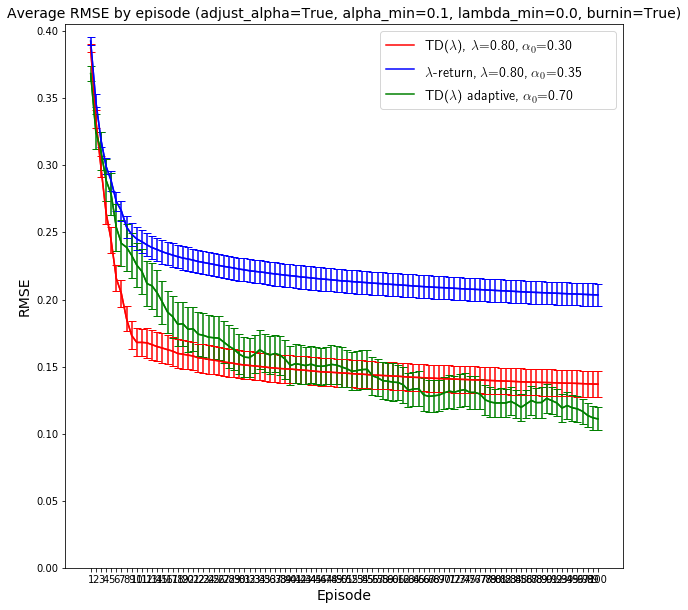

In [14]:
plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], df_rmse_by_episode_td['rmse_se'], color="red", fontsize=fontsize)
plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], df_rmse_by_episode_mc['rmse_se'], color="blue", hold=True, fontsize=fontsize)
plot_rmse_by_episode(df_rmse_by_episode_td_adap['rmse_mean'], df_rmse_by_episode_td_adap['rmse_se'], color="green", hold=True,
                     subtitle="(adjust_alpha={}, alpha_min={}, lambda_min={}, burnin={})".format(adjust_alpha, alpha_min, lambda_min, burnin), fontsize=fontsize)
rc('text', usetex=True)
plt.legend([r'TD($\lambda$), $\lambda$={:.2f}, $\alpha_0$={:.2f}'.format(lambdas_opt['td'], alphas_opt['td']),
            r'$\lambda$-return, $\lambda$={:.2f}, $\alpha_0$={:.2f}'.format(lambdas_opt['mc'], alphas_opt['mc']),
            r'TD($\lambda$) adaptive, $\alpha_0$={:.2f}'.format(alphas_opt['td_adap'])], fontsize=fontsize)
rc('text', usetex=False)
plt.savefig("results/SimulateTDLambda-Gridworld1D-AdaptiveTDLambda-v{}-adjust_alpha={},alpha_min={},lambda_min={},burnin={}-Episodes100.png" \
            .format(version, adjust_alpha, alpha_min, lambda_min, burnin))

We observe that the RMSE starts increasing back in all cases, and that the $\lambda$-adaptive TD method attains a larger RMSE value than the other two methods.

This is most likely due to the fact that **the $\alpha$ parameter is not decreased with time**, as required for convergence.

This is the next thing to try, namely, to decrease $\alpha$ appropriately with time.